# Brain Observatory Stimuli
The next few sections will describe how to understand the various stimulus tables present in the NWB file.  First, here is a function we can use to plot when a given stimulus condition is on the screen.  We'll use this further down.

Download this notebook in .ipynb format <a href='brain_observatory_stimuli.ipynb'>here</a>.

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")

# Drifting Gratings
The drifting gratings stimulus describes the temporal frequency and direction of motion of the displayed grating.  We can use this information to figure out when a given stimulus condition (temporal frequency + orientation) is visible during the experiment.

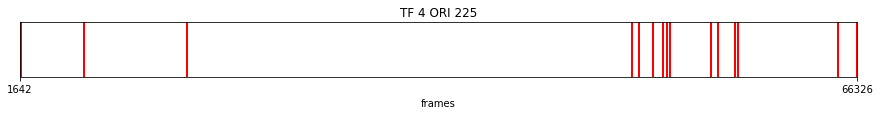

In [11]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501940850)

# this is a pandas DataFrame. find trials with a given stimulus condition.
temporal_frequency = 4
orientation = 225
stim_table = data_set.get_stimulus_table('drifting_gratings')
stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & (stim_table.orientation == orientation)]

# plot the trials
plot_stimulus_table(stim_table, "TF %d ORI %d" % (temporal_frequency, orientation))

# Static Gratings Stimulus
This stimulus table is very similar to the drifting grating stimulus table.  Static gratings have three parameters: spatial frequency, orientation, and phase.  We can make a similar plot to identify frame ranges with a given paramerization.

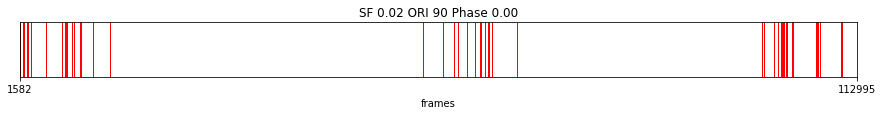

In [23]:
data_set = boc.get_ophys_experiment_data(501498760)

# this is a pandas DataFrame. find trials with a given stimulus condition.
spatial_frequency = 0.02
orientation = 90
phase = 0.0
stim_table = data_set.get_stimulus_table('static_gratings')
stim_table = stim_table[(stim_table.spatial_frequency == spatial_frequency) & \
                        (stim_table.orientation == orientation) & \
                        (stim_table.phase == phase) ]

# plot the trials
plot_stimulus_table(stim_table, "SF %.02f ORI %d Phase %.02f" % (spatial_frequency, orientation, phase))

# Natural Scenes Stimulus
The natural scene stimulus is simply a series of static images.  The natural scene template section of the NWB file contains the array of images.

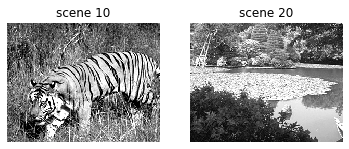

In [14]:
data_set = boc.get_ophys_experiment_data(501498760)

scene_nums = [10, 20]

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes
fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)

The natural scenes stimulus table just describes when a given scene is on the screen.  We can use this to find when the images above are visible.

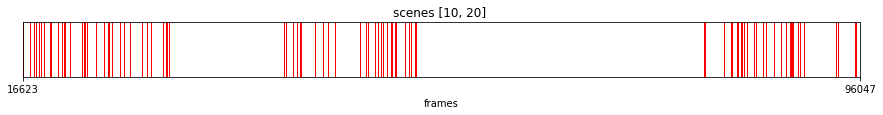

In [15]:
data_set = boc.get_ophys_experiment_data(501498760)

# the natural scenes stimulus table describes when each scene is on the screen
stim_table = data_set.get_stimulus_table('natural_scenes')

# build up a mask of trials for which one of a list of scenes is visible
trial_mask = stim_table.frame == -2
for scene in scene_nums:
    trial_mask |= (stim_table.frame == scene)
stim_table = stim_table[trial_mask]

# plot the trials
plot_stimulus_table(stim_table, "scenes %s " % scene_nums)

# Natural Movie Stimulus
The natural movie stimulus is very similar to the natural scene stimulus in terms of data structures.  Let's take a look at one frame of the "natural_movie_one" clip.

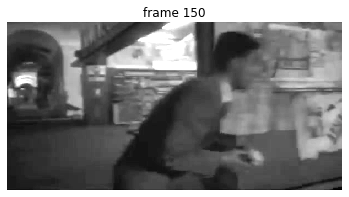

In [17]:
data_set = boc.get_ophys_experiment_data(501498760)

# read in the natural movie one clip
movie = data_set.get_stimulus_template('natural_movie_one')

# display a random frame for reference
frame = 150
plt.imshow(movie[frame,:,:], cmap='gray')
plt.axis('off')
plt.title('frame %d' % frame)
plt.show()

We can now take a look at the stimulus table to see when a given frame (or range of frames) is played to the mouse.  Here you can see that there are 10 repetitions of the video.

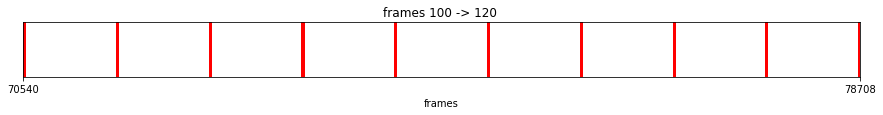

In [18]:
data_set = boc.get_ophys_experiment_data(501498760)

# read in the stimulus table, which describes when a given frame is displayed
stim_table = data_set.get_stimulus_table('natural_movie_one')

# find out when a particular frame range is displayed
frame_range = [ 100, 120 ]
stim_table = stim_table[(stim_table.frame >= frame_range[0]) & (stim_table.frame <= frame_range[1])]

plot_stimulus_table(stim_table, "frames %d -> %d " % (frame_range[0], frame_range[1]))

# Locally Sparse Noise Stimulus
This is essentially a 28x16 pixel movie, so it is again similar to the natural movie and natural scene stimuli.  One extra complication is that a nontrivial number of pixels from the movie are pushed off screen after warping the stimulus, so we provide some helper utilities to identify these pixels.

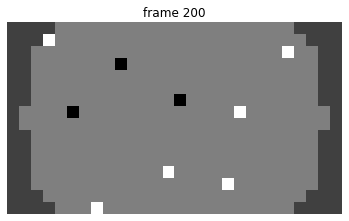

In [19]:
data_set = boc.get_ophys_experiment_data(505693621)

# read in the locally sparse noise stimulus movie.  
# the 'mask_offscreen' argument will set off-screen grid locations to LocallySparseNoise.LSN_OFF_SCREEN
lsn_movie, offscreen_mask = data_set.get_locally_sparse_noise_stimulus_template('locally_sparse_noise',
                                                                                mask_off_screen=True)

# show a single frame of the stimulus for reference
frame = 200
plt.imshow(lsn_movie[frame,:,:], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('frame %d' % frame)
plt.show()

We can now take a look at the movie to determine the frame numbers for which a given grid location is 'on' or 'off' in the movie.

In [20]:
import numpy as np
from allensdk.brain_observatory.locally_sparse_noise import LocallySparseNoise

# find frames at a given grid location that are 'on'
loc = (10,15)
on_frames = np.where(lsn_movie[:,loc[0],loc[1]] == LocallySparseNoise.LSN_ON)[0]

# pull these trials out of the stimulus table
stim_table = data_set.get_stimulus_table('locally_sparse_noise')
stim_table = stim_table.loc[on_frames]

plot_stimulus_table(stim_table, "loc (%d,%d) " % loc)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'